<a href="https://colab.research.google.com/github/gsgh3016/baekjoon/blob/main/1003_gratduate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Source Separation
https://datapeaker.com/big-data/dar-pequenos-pasos-en-el-aprendizaje-por-refuerzo/

---
  5번 항목

논문: http://ijcert.org/ems/ijcert_papers/V3I1103.pdf

github: https://github.com/IoSR-Surrey/untwist



# Drive 연동

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset 다운로드


---
URL: https://www.loria.fr/~aliutkus/DSD100subset.zip

다운로드 한 경우 실행 필요 없음


In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# code.py
# Link:https://code.i-harness.com/ko/q/6e87e6
from requests import get  # to make GET request

def download(url, file_name):
    with open(file_name, "wb") as file:   # open in binary mode
        response = get(url)               # get request
        file.write(response.content)      # write to file

if __name__ == '__main__':
	url = "https://www.loria.fr/~aliutkus/DSD100subset.zip"
	download(url,"DSD100subset.zip")

In [ ]:
# Dataset 압축 해제

import zipfile
         
fantasy_zip = zipfile.ZipFile('/content/DSD100subset.zip')
fantasy_zip.extractall('/content')
 
fantasy_zip.close()

# 환경설정

In [ ]:
!git clone https://github.com/IoSR-Surrey/untwist.git
#github에서 파일 가져오기
#%cd 사용하지 말 것

fatal: destination path 'untwist' already exists and is not an empty directory.


반드시 실행해야 할 항목들

In [ ]:
!pip install git+https://github.com/IoSR-Surrey/untwist

#colab 가상 linux sever에 untwist, utils 패키지 설치
#코드 실행 시, 반드시 실행!!!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/IoSR-Surrey/untwist to /tmp/pip-req-build-u05l5uax
  Running command git clone -q https://github.com/IoSR-Surrey/untwist /tmp/pip-req-build-u05l5uax


In [ ]:
!pip install cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 실제 모델 실행

example 1. untwist/examples/mlp_example.py

#execution - mlp_example.py

In [ ]:
#!pip install -r /content/untwist.egg-info/requires.txt

In [ ]:
#!!chmod +x /content/untwist/setup.py
#!/content/untwist/setup.py install

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import theano
from untwist import data
from untwist import transforms
from untwist import neuralnetworks
# from wave import open
floatX = theano.config.floatX

In [ ]:
from untwist import data
from collections import namedtuple
import os


Stems = namedtuple('Stems', 'drums bass other vocals accompaniment mixture')


def get_stems(song_idx=0,
              path_to_dsd100_subset='/scratch/DSD100subset',
              mono=False):
    '''
    Load drums, bass, 'other', vocals, accompaniment and the mixture from four
    songs of the Demixing Secret Database 100 (DSD100).
    song_idx: int (0, 1, 2, or 3)
              index of the song to load
    path_to_dsd100_subset: string
              path to https://www.loria.fr/~aliutkus/DSD100subset.zip
    mono: bool
          Converts wavs to mono if true.
    '''

    if song_idx == 0:
        path = "Sources/Test/005 - Angela Thomas Wade - Milk Cow Blues"
    elif song_idx == 1:
        path = "Sources/Test/049 - Young Griffo - Facade"
    elif song_idx == 2:
        path = "Sources/Dev/055 - Angels In Amplifiers - I'm Alright"
    elif song_idx == 3:
        path = "Sources/Dev/081 - Patrick Talbot - Set Me Free"

    path = os.path.join(path_to_dsd100_subset,
                        path)

    if mono:
        def _func(x):
            return x.to_mono()
    else:
        def _func(x):
            return x

    stems = [_func(data.audio.Wave.read(os.path.join(path, _ + '.wav')))
             for _ in ['drums', 'bass', 'other', 'vocals']
             ]

    stems = Stems(
        drums=stems[0],
        bass=stems[1],
        other=stems[2],
        vocals=stems[3],
        accompaniment=sum(stems[:3]),
        mixture=sum(stems),
    )

    return stems

In [ ]:
# Load the stems
stems = get_stems(song_idx=0,
                  path_to_dsd100_subset='/content/DSD100subset',
                  mono=True)

train_frames = 2000
fft_size = 1024
n_bins = fft_size // 2 + 1

stft = transforms.STFT(fft_size=fft_size)
istft = transforms.ISTFT(fft_size=fft_size)

In [ ]:
# Compute spectrograms of the mixture, vocals and accompaniment
mix_spec = stft.process(stems.mixture)
vocals_spec = stft.process(stems.vocals)
accompaniment_spec = stft.process(stems.accompaniment)

In [ ]:
# The network and training algorithm
mlp = neuralnetworks.MLP(input_size=n_bins,
                         output_size=n_bins,
                         hidden_sizes=[n_bins, n_bins])
# mlp : multi-layer perceptron

In [ ]:
# SGD: Stochastic Gradient Descent
sgd = neuralnetworks.SGD(mlp,
                         learning_rate=0.05,
                         momentum=0.2,
                         batch_size=200,
                         iterations=100)

In [ ]:
# Ideal mask for the vocals
ideal_mask = data.audio.BinaryMask(
    vocals_spec.magnitude(), accompaniment_spec.magnitude())

In [ ]:
# Create dataset for adding training data
ds = data.dataset.Dataset(x_width=n_bins,
                          x_type=floatX,
                          y_width=n_bins,
                          y_type=np.bool_)

In [ ]:
'''
Mixture spectrogram as input, ideal mask for vocal as output
Need to transpose so each column is a frequency bin
'''
Xtrain = mix_spec[:, :train_frames].magnitude().T
Ytrain = ideal_mask[:, :train_frames].T

In [ ]:
# Add to the dataset and standardise
ds.add(Xtrain, Ytrain)
ds.standardize()
ds.shuffle()

In [ ]:
# Go on then...
sgd.train(ds)

0 74.91259273138813
-inf
1 59.26433351009989
-15.648259221288242
2 55.79574855987552
-3.4685849502243684
3 53.94453317807383
-1.851215381801687
4 52.467186208053604
-1.4773469700202284
5 51.204060773112886
-1.2631254349407186
6 49.86858600548691
-1.3354747676259748
7 48.40442933943968
-1.4641566660472307
8 46.88172773623022
-1.5227016032094625
9 45.3705864299644
-1.51114130626582
10 43.97062958223104
-1.3999568477333568
11 42.7403884339429
-1.230241148288144
12 41.703894581281475
-1.0364938526614225
13 40.8550752435245
-0.8488193377569715
14 40.163644887347914
-0.6914303561765891
15 39.59112734377514
-0.5725175435727721
16 39.12003007005922
-0.4710972737159196
17 38.72671202973257
-0.39331804032665474
18 38.390895929321076
-0.3358161004114919
19 38.09566347984186
-0.2952324494792151
20 37.8439977426822
-0.25166573715966223
21 37.60335088654142
-0.24064685614077774
22 37.448923306080886
-0.15442758046053484
23 37.32373068662273
-0.1251926194581543
24 37.78084882936521
0.4571181427424804

In [ ]:
# Predict using remaining spectra
test_data = mix_spec[:, train_frames:].magnitude().T
test_data = ds.standardize_points(test_data)
test_prediction = sgd.predict(test_data)

In [ ]:
# Predict the mask, threshold to get binary (> 0.5)
estimated_mask = ideal_mask[:, train_frames:].copy()
estimated_mask[:] = test_prediction.T > 0.5

In [ ]:
# Example audio
ideal_vocal = mix_spec[:, train_frames:] * ideal_mask[:, train_frames:]
istft.process(ideal_vocal).write('ideal_masked_vocal.wav')
predicted_vocal = mix_spec[:, train_frames:] * estimated_mask
istft.process(predicted_vocal).write('predicted_vocal.wav')

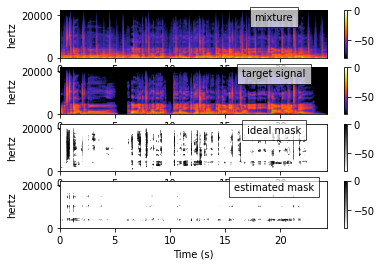

In [ ]:
# Transpose back to bin x time and plot
plt.subplot(4, 1, 1)
test_data.T.plot(title="mixture", xlabel=False)
plt.subplot(4, 1, 2)
vocals_spec[:, train_frames:].plot(title="target signal", xlabel=False)
plt.subplot(4, 1, 3)
ideal_mask[:, train_frames:].plot(title="ideal mask", xlabel=False)
plt.subplot(4, 1, 4)
estimated_mask.plot(title="estimated mask")
plt.show()

# execution - rpca_example.py

untwist/examples/rpca_example.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from untwist import factorizations
from untwist import data
from untwist import transforms

In [ ]:
from untwist import data
from collections import namedtuple
import os


Stems = namedtuple('Stems', 'drums bass other vocals accompaniment mixture')


def get_stems(song_idx=0,
              path_to_dsd100_subset='/scratch/DSD100subset',
              mono=False):
    '''
    Load drums, bass, 'other', vocals, accompaniment and the mixture from four
    songs of the Demixing Secret Database 100 (DSD100).

    song_idx: int (0, 1, 2, or 3)
              index of the song to load
    path_to_dsd100_subset: string
              path to https://www.loria.fr/~aliutkus/DSD100subset.zip
    mono: bool
          Converts wavs to mono if true.
    '''

    if song_idx == 0:
        path = "Sources/Test/005 - Angela Thomas Wade - Milk Cow Blues"
    elif song_idx == 1:
        path = "Sources/Test/049 - Young Griffo - Facade"
    elif song_idx == 2:
        path = "Sources/Dev/055 - Angels In Amplifiers - I'm Alright"
    elif song_idx == 3:
        path = "Sources/Dev/081 - Patrick Talbot - Set Me Free"

    path = os.path.join(path_to_dsd100_subset,
                        path)

    if mono:
        def _func(x):
            return x.to_mono()
    else:
        def _func(x):
            return x

    stems = [_func(data.audio.Wave.read(os.path.join(path, _ + '.wav')))
             for _ in ['drums', 'bass', 'other', 'vocals']
             ]

    stems = Stems(
        drums=stems[0],
        bass=stems[1],
        other=stems[2],
        vocals=stems[3],
        accompaniment=sum(stems[:3]),
        mixture=sum(stems),
    )

    return stems

In [ ]:
stems = get_stems(song_idx=2,
                  path_to_dsd100_subset='/content/drive/MyDrive/untwist/DSD100subset',
                  mono=True)

stft = transforms.STFT()
istft = transforms.ISTFT()
rpca = factorizations.RPCA(iterations=100)


In [ ]:
# Try with vocals over repetitive music background
mixture_spec = stft.process(stems.mixture)

In [ ]:
# this will take some time
low_rank_l, sparse_s = rpca.process(mixture_spec.magnitude())

0 0.6015909664543436
1 0.35640893606010554
2 0.31054578982520564
3 0.2360791023803096
4 0.17280706728988957
5 0.13352046571959503
6 0.10247388704813966
7 0.07699999509114393
8 0.05708773299049835
9 0.040635617382860194
10 0.028264182311893277
11 0.019051076522943654
12 0.012442811941523848
13 0.00805323326677659
14 0.005158483155193925
15 0.003257776014481453
16 0.002029140905195498
17 0.0012428692669708644
18 0.0007503064993448321
19 0.00044697270087741905
20 0.00026314417877378905
21 0.0001536587253739484
22 8.960622673410973e-05
23 5.2233853071370386e-05
24 3.0378353648614936e-05
25 1.76334703373389e-05
26 1.0232142389625677e-05
27 5.975112210191856e-06
28 3.556033414755545e-06
29 2.1622315427093055e-06
30 1.3330168690420377e-06
31 8.333464643210988e-07
32 5.303535731213363e-07
33 3.4322913537335044e-07
34 2.2437798629835558e-07
35 1.482346089182137e-07
36 9.914570056586899e-08
37 6.695764483370601e-08
38 4.53917362327715e-08
39 3.087754503441713e-08
40 2.127919699378021e-08
41 1.67

In [ ]:
# Calculate binary mask and synthesise vocals and accompaniment
mask = data.audio.BinaryMask(sparse_s, low_rank_l, 0)
istft.process(mixture_spec * mask).normalize().write(
    "vocal_estimate_mask.wav")
istft.process(mixture_spec * (1 - mask)).normalize().write(
    "accomp_estimate_mask.wav")
stems.mixture.write("mixture.wav")

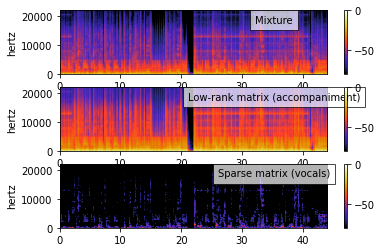

In [ ]:
plt.subplot(3, 1, 1)
mixture_spec.plot(xlabel=False, title="Mixture")
plt.subplot(3, 1, 2)
low_rank_l.plot(xlabel=False, title="Low-rank matrix (accompaniment)")
plt.subplot(3, 1, 3)
sparse_s.plot(xlabel=False, title="Sparse matrix (vocals)")
plt.show()

#filter design

https://audio-dspy.readthedocs.io/en/latest/tutorials/eq_tutorial.html

basic filter design

In [ ]:
!pip install audio_dspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


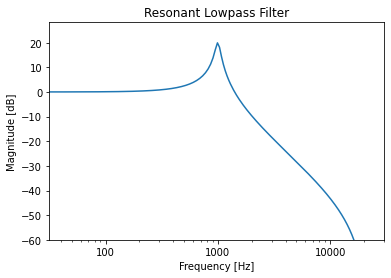

In [ ]:
import audio_dspy as adsp
fs = 44100 # set sample rate
b, a = adsp.design_LPF2(1000, 10, fs)
adsp.plot_magnitude_response(b, a, fs=fs)

# plot settings
import matplotlib.pyplot as plt
plt.title('Resonant Lowpass Filter')
plt.ylim(-60)
plt.show()

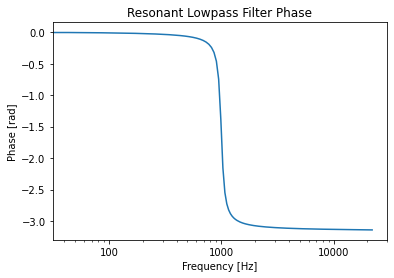

In [ ]:
adsp.plot_phase_response(b, a, fs=fs)
plt.title('Resonant Lowpass Filter Phase')
plt.show()

processing audio with filters

In [ ]:
# generate white noise signal
import numpy as np
N = 1024
x = np.random.rand(N) * 2 - 1 # range: (-1, 1)

# Design filter
import audio_dspy as adsp
fs = 44100
b, a = adsp.design_LPF2(1000, 0.707, fs)

# Setup filter
filter = adsp.Filter(2, fs)
filter.set_coefs(b, a)

# Process audio
filter.reset()
y = filter.process_block(x)

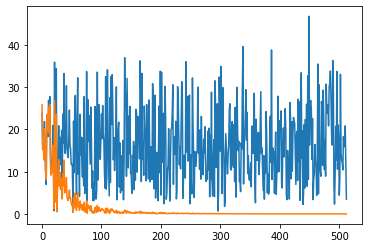

In [ ]:
plt.plot(np.abs(np.fft.rfft(x)))
plt.plot(np.abs(np.fft.rfft(y)))
plt.show()

designing and using an EQ

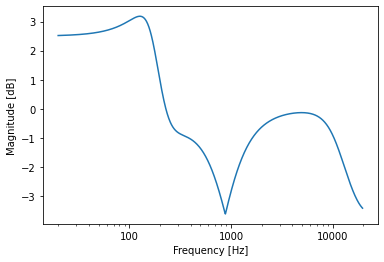

In [ ]:
import audio_dspy as adsp
import numpy as np
import matplotlib.pyplot as plt

fs = 44100 # sample rate
worN = np.logspace(1, 3.3, num=1000, base=20) # frequencies to plot

# design EQ
eq = adsp.EQ(fs)
eq.add_LPF(10000, 0.707)
eq.add_lowshelf(200, 1.4, 2)
eq.add_notch(880, 0.707)

# plot EQ magnitude response
eq.plot_eq_curve(worN=worN)
plt.show()